# R-STDP: Creature Learning in 1D World

This notebook demonstrates **Reward-modulated Spike-Timing Dependent Plasticity (R-STDP)** - a biologically plausible learning rule that combines Hebbian learning with reinforcement signals.

## The Problem

A simple creature lives in a 1D world. It must learn to:
- **Approach food** (green) → positive reward
- **Avoid danger** (red) → positive reward for moving away

## Architecture

```
┌─────────────────────────────────────────────────────────┐
│                   SENSORY NEURONS (4)                   │
│   food_left   food_right   danger_left   danger_right   │
└──────────┬────────┬────────────┬────────────┬───────────┘
           │        │            │            │
           ▼        ▼            ▼            ▼
┌─────────────────────────────────────────────────────────┐
│              Plastic Synapses (R-STDP)                  │
│         Weights change based on reward signal           │
└──────────┬──────────────────────────────────┬───────────┘
           ▼                                  ▼
┌─────────────────────┐          ┌─────────────────────┐
│    MOTOR: LEFT      │          │    MOTOR: RIGHT     │
└─────────────────────┘          └─────────────────────┘
```


## 1. Setup


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Import our modules
from world import World, Action, EntityType
from creature import CreatureBrain
from simulation import Simulation, EpisodeStats
from visualization import (
    plot_training_progress,
    plot_weight_evolution,
    plot_weight_matrix,
    plot_world_state,
    plot_behavior_comparison
)

print("Imports successful!")


Imports successful!


## 2. Create the World

Our 1D world spans from -10 to +10. Food and danger appear randomly.


In [2]:
# Create the world
world = World(
    world_size=10.0,      # World spans [-10, 10]
    spawn_prob=0.4,       # 40% chance to spawn entity each step
    despawn_prob=0.1,     # 10% chance to despawn
    seed=42
)

# Reset and show initial state
state = world.reset()
print("Initial world state:")
print(world.render_ascii(width=50))
print(f"\nSensory input: {world.get_sensory_input()}")
print("  (food_left, food_right, danger_left, danger_right)")


Initial world state:
|------------------------C-------------------------|
 C=0.0

Sensory input: (0, 0, 0, 0)
  (food_left, food_right, danger_left, danger_right)


## 3. Create the Creature's Brain

The brain has plastic synapses that will be trained with R-STDP.


Initial synaptic weights:
[[0.37294075 0.12152841 0.18814395 0.17374872]
 [0.17036236 0.4248378  0.469338   0.21062976]]

Weight matrix layout:
         [food_L, food_R, danger_L, danger_R]
move_L   [  w00,    w01,     w02,      w03  ]
move_R   [  w10,    w11,     w12,      w13  ]


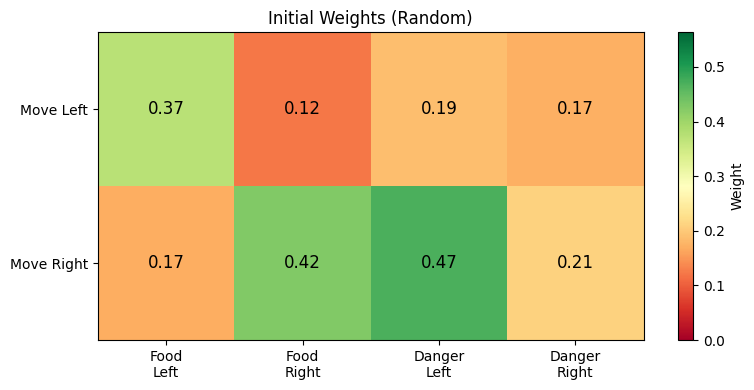

In [3]:
# Create the brain with random initial weights
brain = CreatureBrain(
    learning_rate=0.3,    # How fast to learn
    initial_weight=0.5,   # Initial random weight range
    seed=123
)

print("Initial synaptic weights:")
print(brain.get_weights())
print("\nWeight matrix layout:")
print("         [food_L, food_R, danger_L, danger_R]")
print("move_L   [  w00,    w01,     w02,      w03  ]")
print("move_R   [  w10,    w11,     w12,      w13  ]")

# Visualize initial weights
fig = plot_weight_matrix(brain.get_weights(), "Initial Weights (Random)")
plt.show()


## 4. Evaluate BEFORE Training

Let's see how the creature behaves with random weights (no training yet).


In [4]:
# Create simulation
sim = Simulation(world, brain)

# Run evaluation WITHOUT learning
print("="*50)
print("BEFORE TRAINING - Random behavior")
print("="*50)

pre_training_stats = []
for ep in range(5):
    stats = sim.run_episode(num_steps=50, learn=False)
    pre_training_stats.append(stats)
    print(f"Episode {ep+1}: Reward={stats.total_reward:.0f}, Accuracy={stats.accuracy:.1%}")

avg_pre_accuracy = np.mean([s.accuracy for s in pre_training_stats])
print(f"\nAverage accuracy: {avg_pre_accuracy:.1%} (random ~ 50%)")


BEFORE TRAINING - Random behavior
Episode 1: Reward=33, Accuracy=84.6%
Episode 2: Reward=36, Accuracy=100.0%
Episode 3: Reward=33, Accuracy=97.1%
Episode 4: Reward=34, Accuracy=89.5%
Episode 5: Reward=30, Accuracy=73.2%

Average accuracy: 88.9% (random ~ 50%)


## 5. Train with R-STDP

Now let's train the creature. The R-STDP rule will:
- **Strengthen** connections that led to rewarded actions
- **Weaken** connections that led to unrewarded actions


In [5]:
# Reset brain for training
brain.reset_weights()

# Training parameters
NUM_EPISODES = 30
STEPS_PER_EPISODE = 100

print("="*50)
print("TRAINING with R-STDP")
print("="*50)
print(f"Episodes: {NUM_EPISODES}, Steps per episode: {STEPS_PER_EPISODE}\n")

training_stats = []
for ep in range(NUM_EPISODES):
    stats = sim.run_episode(num_steps=STEPS_PER_EPISODE, learn=True)
    training_stats.append(stats)
    
    if (ep + 1) % 5 == 0:
        recent_acc = np.mean([s.accuracy for s in training_stats[-5:]])
        print(f"Episode {ep+1:2d}: Reward={stats.total_reward:5.0f}, "
              f"Accuracy={stats.accuracy:.1%}, Recent avg={recent_acc:.1%}")

print(f"\nTraining complete!")


TRAINING with R-STDP
Episodes: 30, Steps per episode: 100

Episode  5: Reward=   84, Accuracy=100.0%, Recent avg=93.0%
Episode 10: Reward=   73, Accuracy=100.0%, Recent avg=100.0%
Episode 15: Reward=   70, Accuracy=100.0%, Recent avg=100.0%
Episode 20: Reward=   72, Accuracy=100.0%, Recent avg=100.0%
Episode 25: Reward=   68, Accuracy=100.0%, Recent avg=100.0%
Episode 30: Reward=   70, Accuracy=100.0%, Recent avg=100.0%

Training complete!


## 6. Visualize Training Progress


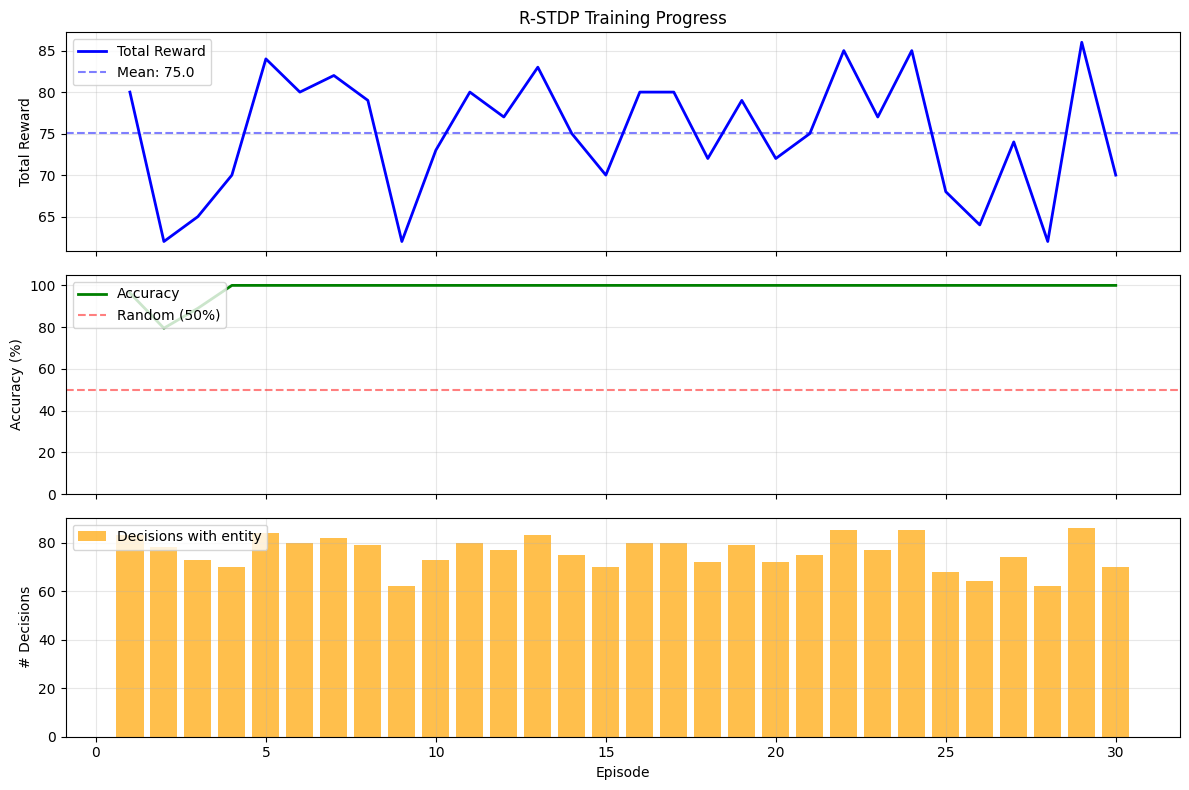

In [6]:
# Plot training progress
fig = plot_training_progress(training_stats, "R-STDP Training Progress")
plt.savefig('training_progress.png', dpi=150)
plt.show()


## 7. Analyze Learned Weights

Let's see how the weights evolved during training.


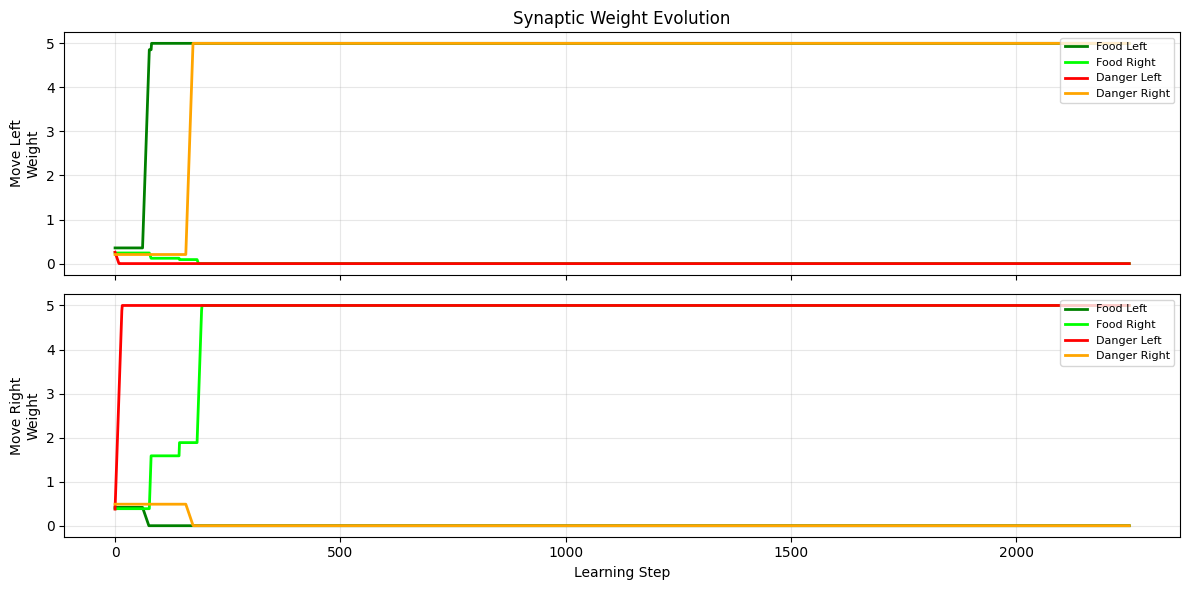


Final weights after training:
[[5. 0. 0. 5.]
 [0. 5. 5. 0.]]


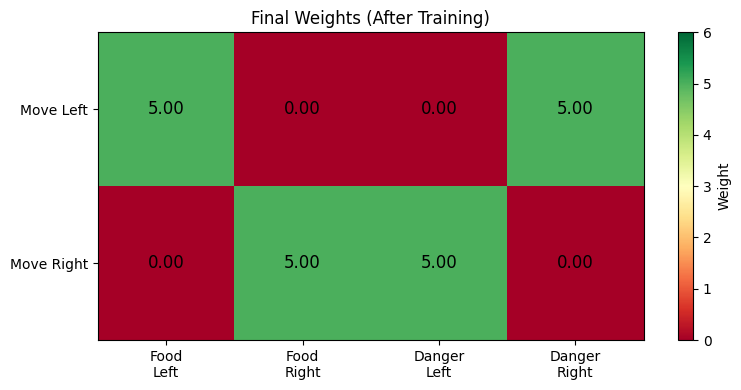

In [7]:
# Plot weight evolution
fig = plot_weight_evolution(brain.weight_history)
plt.savefig('weight_evolution.png', dpi=150)
plt.show()

# Show final weights
print("\nFinal weights after training:")
print(brain.get_weights())

fig = plot_weight_matrix(brain.get_weights(), "Final Weights (After Training)")
plt.savefig('final_weights.png', dpi=150)
plt.show()


## 8. Evaluate AFTER Training

Let's see how the trained creature performs.


In [8]:
# Evaluate trained creature (no learning)
print("="*50)
print("AFTER TRAINING - Learned behavior")
print("="*50)

post_training_stats = []
for ep in range(5):
    stats = sim.run_episode(num_steps=50, learn=False)
    post_training_stats.append(stats)
    print(f"Episode {ep+1}: Reward={stats.total_reward:.0f}, Accuracy={stats.accuracy:.1%}")

avg_post_accuracy = np.mean([s.accuracy for s in post_training_stats])
print(f"\nAverage accuracy: {avg_post_accuracy:.1%}")


AFTER TRAINING - Learned behavior
Episode 1: Reward=37, Accuracy=100.0%
Episode 2: Reward=38, Accuracy=100.0%
Episode 3: Reward=37, Accuracy=100.0%
Episode 4: Reward=33, Accuracy=100.0%
Episode 5: Reward=30, Accuracy=100.0%

Average accuracy: 100.0%


## 9. Behavior Analysis


In [9]:
# Analyze what the creature learned
analysis = brain.get_expected_behavior()

print("="*50)
print("BEHAVIOR ANALYSIS")
print("="*50)
print(f"\nWhen FOOD is on the LEFT:   → Creature moves {analysis['food_left_response']}")
print(f"When FOOD is on the RIGHT:  → Creature moves {analysis['food_right_response']}")
print(f"When DANGER is on the LEFT: → Creature moves {analysis['danger_left_response']}")
print(f"When DANGER is on the RIGHT:→ Creature moves {analysis['danger_right_response']}")

print(f"\n✓ Food behavior correct:   {analysis['food_behavior_correct']}")
print(f"✓ Danger behavior correct: {analysis['danger_behavior_correct']}")
print(f"\n{'🎉 FULLY TRAINED!' if analysis['fully_trained'] else '⚠️ Needs more training'}")


BEHAVIOR ANALYSIS

When FOOD is on the LEFT:   → Creature moves LEFT
When FOOD is on the RIGHT:  → Creature moves RIGHT
When DANGER is on the LEFT: → Creature moves RIGHT
When DANGER is on the RIGHT:→ Creature moves LEFT

✓ Food behavior correct:   True
✓ Danger behavior correct: True

🎉 FULLY TRAINED!


## 10. Summary Comparison


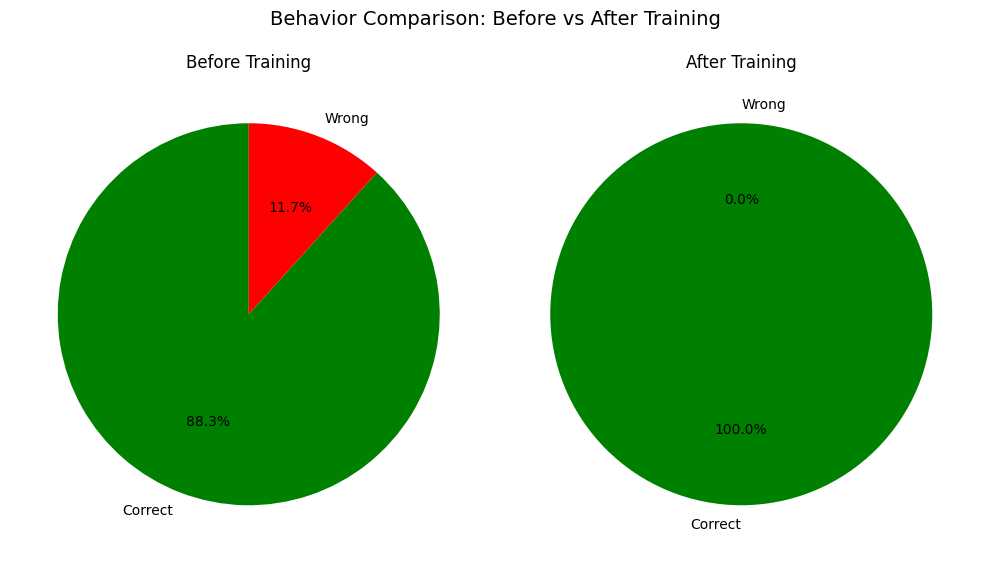


SUMMARY
Pre-training accuracy:  88.9%
Post-training accuracy: 100.0%
Improvement: +11.1%


In [10]:
# Compare before and after training
fig = plot_behavior_comparison(pre_training_stats, post_training_stats)
plt.savefig('behavior_comparison.png', dpi=150)
plt.show()

# Print summary
print("\n" + "="*50)
print("SUMMARY")
print("="*50)
print(f"Pre-training accuracy:  {avg_pre_accuracy:.1%}")
print(f"Post-training accuracy: {avg_post_accuracy:.1%}")
print(f"Improvement: {(avg_post_accuracy - avg_pre_accuracy)*100:+.1f}%")
print("="*50)


## 11. Understanding R-STDP

### How the learning works:

1. **Sensory Input** → Activates sensory neurons (food_left, food_right, danger_left, danger_right)

2. **Motor Decision** → Based on weighted sum: `motor_activation = weights @ sensory_input`

3. **Action** → Winner-take-all selects LEFT or RIGHT movement

4. **Reward** → Environment provides reward signal:
   - +1 for moving toward food
   - +1 for moving away from danger
   - 0 otherwise

5. **Weight Update** (R-STDP rule):
   ```
   Δw = learning_rate × reward × pre_activity × post_activity
   ```
   
   - If reward > 0: strengthen connections that led to this action
   - If reward < 0: weaken connections that led to this action

### Expected final weights:

| Weight | Should be | Why |
|--------|-----------|-----|
| food_left → move_left | HIGH | Approach food on left |
| food_right → move_right | HIGH | Approach food on right |
| danger_left → move_right | HIGH | Escape danger on left |
| danger_right → move_left | HIGH | Escape danger on right |
